# Imports:

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, losses
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
from PIL import Image
from termcolor import colored

# Load Coin Dataset:

## Settings:

In [20]:
# Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# dataset_dir = '/content/drive/MyDrive/images_grade/'
# model_dir = '/content/drive/MyDrive/coin_grader_model/'

# Local
dataset_dir = 'images_grade/'
model_dir = 'coin_grader_model/'

batch_size = 32
img_size = 256

## Image augmentation:

In [21]:
class RandomBrightness(layers.Layer):
  def __init__(self, delta, **kwargs):
    super(RandomBrightness, self).__init__(**kwargs)
    self.delta = delta

  def __call__(self, images, **kwargs):
    def random_brightness(image):
      return tf.image.random_brightness(image, self.delta)
    images = tf.map_fn(random_brightness, images)
    return tf.clip_by_value(images, 0, 1)

class RandomContrast(layers.Layer):
  def __init__(self, range, **kwargs):
    super(RandomContrast, self).__init__(**kwargs)
    self.range = range

  def __call__(self, images, **kwargs):
    def random_contrast(image):
      return tf.image.random_contrast(image, self.range[0], self.range[1])
    images = tf.map_fn(random_contrast, images)
    return tf.clip_by_value(images, 0, 1)

augment = models.Sequential([
  layers.RandomZoom((0, 0.2), fill_mode="constant", fill_value=1),
  layers.RandomRotation(0.05, fill_mode="constant", fill_value=1),
  layers.RandomTranslation(0.1, 0.1, fill_mode="constant", fill_value=1),
  RandomBrightness(0.2),
  RandomContrast((0.8, 1))
])

## Load dataset:

In [22]:
labels = listdir(dataset_dir)
labels.sort()

if '.DS_Store' in labels:
  labels.remove('.DS_Store')

dataset = preprocessing.image_dataset_from_directory(
  dataset_dir,
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_size, img_size),
  shuffle=True,
)
dataset = dataset.map(lambda image, label: (image / 255.0, label))
datasets = [dataset.map(lambda image, label: (augment(image), label)) for _ in range(9)]
for ds in datasets:
  dataset = dataset.concatenate(ds)

Found 2455 files belonging to 8 classes.


# Display Coin Images:

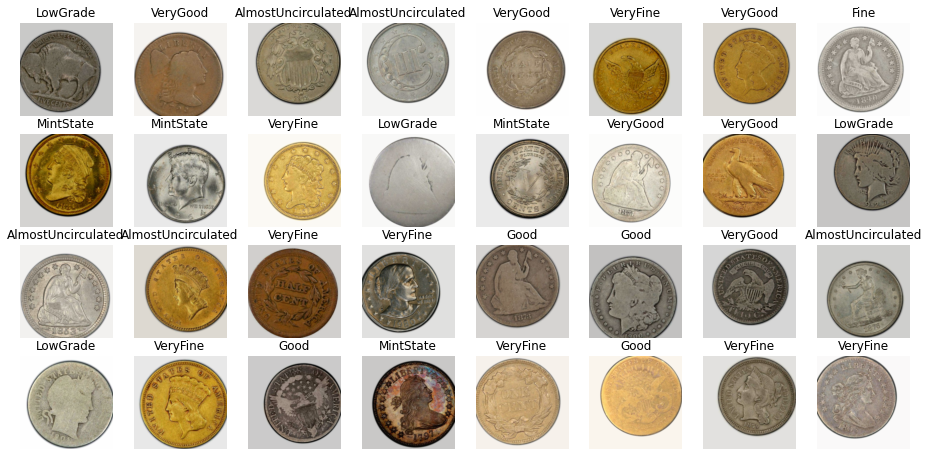

In [23]:
fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = next(dataset.as_numpy_iterator())
X_batch = np.clip(augment(X_batch), 0, 1)
for i in range(batch_size):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[y_batch[i]])

# Create CNN:

In [26]:
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((4, 4)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(8),
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)       

# Train Model:

In [28]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(dataset, epochs=12)

Epoch 1/12
770/770 [==============================] - 404s 524ms/step - loss: 0.9018 - accuracy: 0.6277
Epoch 2/12
770/770 [==============================] - 398s 517ms/step - loss: 0.9140 - accuracy: 0.6281
Epoch 3/12
770/770 [==============================] - 402s 522ms/step - loss: 0.9978 - accuracy: 0.5974
Epoch 4/12
770/770 [==============================] - 382s 496ms/step - loss: 0.8777 - accuracy: 0.6406
Epoch 5/12
770/770 [==============================] - 376s 489ms/step - loss: 0.8324 - accuracy: 0.6600
Epoch 6/12
770/770 [==============================] - 376s 488ms/step - loss: 0.8071 - accuracy: 0.6718
Epoch 7/12
770/770 [==============================] - 376s 489ms/step - loss: 0.7818 - accuracy: 0.6794
Epoch 8/12
770/770 [==============================] - 376s 489ms/step - loss: 0.7692 - accuracy: 0.6855
Epoch 9/12
770/770 [==============================] - 384s 500ms/step - loss: 0.7409 - accuracy: 0.7015
Epoch 10/12
770/770 [==============================] - 403s 524m

# Save/Load Model:

## Save model:

In [29]:
model.save(model_dir)

INFO:tensorflow:Assets written to: coin_grader_model/assets


## Save model using TFLite:

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
with open('coin_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

## Load model:

In [ ]:
model = models.load_model(model_dir)

## Load model using TFLite:

In [ ]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="coin_classifier.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test Images:

In [30]:
correct = {}
total = {}
for i in range(len(labels)):
  correct[i] = 0
  total[i] = 0
for X, y in dataset:
  preds = [np.argmax(pred) for pred in model.predict(X)]
  for i, pred in enumerate(preds):
    true = y[i].numpy()
    if pred == true:
      correct[true] += 1
    total[true] += 1
for label, count in correct.items():
  acc = count / total[label]
  print('%s: %.2f' % (labels[label], acc))

AlmostUncirculated: 0.21
ExtraFine: 0.19
Fine: 0.28
Good: 0.58
LowGrade: 0.93
MintState: 0.99
VeryFine: 0.11
VeryGood: 0.37


1: MintState
2: LowGrade
3: Good
4: AlmostUncirculated
5: Fine


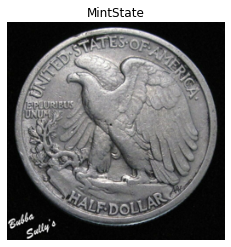

In [48]:
img_name = 'walking_r.jpg'
label = img_name.split('_')[0]

img = Image.open('test_images/%s' % img_name).resize(size=(img_size, img_size))
img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)
img_dataset = tf.data.Dataset.from_tensors([img_data])

# For Standard Model
prediction = model.predict(img_dataset)[0]
ranked = np.argsort(prediction)

# For TFLite Model
# interpreter.set_tensor(input_details[0]['index'], [img_data])
# interpreter.invoke()
# prediction = interpreter.get_tensor(output_details[0]['index'])

def get_color(index):
  if index == -1:
    return 'green' if labels[ranked[index]] == label else 'red'
  else:
    return 'yellow' if labels[ranked[index]] == label else 'white'

for i in range(-1,-6,-1):
  print(colored('%d: %s' % (abs(i), labels[ranked[i]]), get_color(i)))

plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)